In [84]:
import pandas as pd
import numpy as np
from datetime import date, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import openpyxl
from openpyxl.styles import Border, Side, PatternFill, Font, GradientFill, Alignment
from openpyxl.drawing.image import Image
import win32com.client as win32
import os
from PIL import ImageGrab
import win32com.client

olApp = win32.Dispatch('Outlook.Application')
olNS = olApp.GetNameSpace('MAPI')

import sys
sys.path.append("C:\\Users\\KlimovaAnnaA\\Documents\\MyFiles\\Projects\\OCP")
from Defs import merge_SalesUnits
from Defs import merge_Mapping
from Defs import Period
from Defs import new_list
from Defs import export_from_RISKCUSTOM
from Defs import add_in_currency_column
from Defs import concat_columns
from Defs import export_from_WHWEEK

In [85]:
Today = '2024-06-30'

print_to_excel = True

C:\Users\KlimovaAnnaA\Documents\MyFiles\Projects\OCP\Defs.py:174: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_export = pd.read_sql(query, con=connection)
C:\Users\KlimovaAnnaA\Documents\MyFiles\Projects\OCP\Defs.py:93: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_export = pd.read_sql(query, con=connection)
C:\Users\KlimovaAnnaA\AppData\Local\Temp\ipykernel_2180\1125668715.py:23: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  data_unifiedOcp_pivot = data_work_query.pivot_table(ind

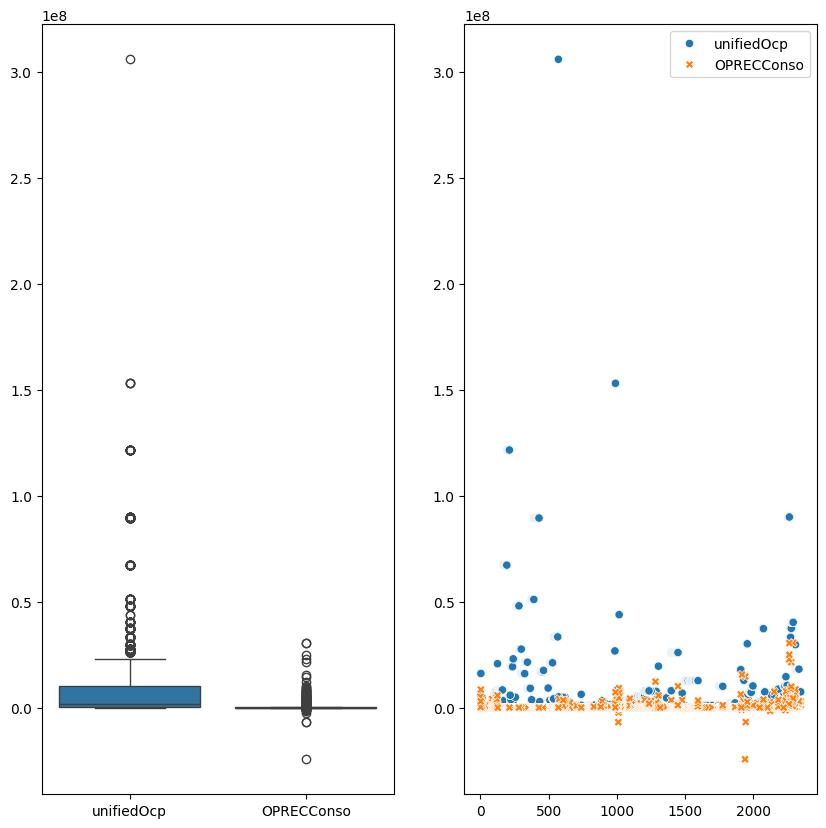

In [132]:
query = f"""
select * 
from xxwh."OPRECConso_detailed"
where "periodDate" = TO_DATE('{Today}', 'YYYY-MM-DD')
and "rowType" = 'on hand'
"""
data_OPRECConso_detailed = export_from_WHWEEK(query)
data_OPRECConso_detailed_work = data_OPRECConso_detailed.loc[data_OPRECConso_detailed['##inserted'] == data_OPRECConso_detailed['##inserted'].max(), ['productGroupNine','businessUnit','dealCurrency','quantity','dealAmount']]
# merge segments
# data_OPRECConso_detailed_work['businessSegment'] = merge_SalesUnits(data_OPRECConso_detailed_work,'businessUnit',merge_col='ocpSegment')

query = f"""
select * 
from "RISKACCESS"."unifiedOcp"
where "reportDate" = TO_DATE('{Today}', 'YYYY-MM-DD')
and "sourceTable" = 'unifiedMaterialMovementSlice_inventory'
"""
data = export_from_RISKCUSTOM(query)
data_work = data[['sourceTable','accountName','holding','buCode','ocpSegment','volumeUsd','salesUnitsId']]

intersection_list = set(data_OPRECConso_detailed_work.productGroupNine.tolist()).intersection(set(data_work.accountName.tolist()))
data_work_query = data_work[data_work.accountName.isin(intersection_list)]
data_unifiedOcp_pivot = data_work_query.pivot_table(index=['holding','buCode','accountName','sourceTable'], values='volumeUsd',aggfunc=sum).reset_index()
data_OPRECConso_query = data_OPRECConso_detailed_work[(data_OPRECConso_detailed_work.productGroupNine.isin(intersection_list))]
data_OPRECConso_pivot = data_OPRECConso_query.pivot_table(index=['businessUnit','productGroupNine', 'quantity'], values='dealAmount',aggfunc=sum).reset_index()

data_USD_merge = data_unifiedOcp_pivot.merge(data_OPRECConso_pivot, how='outer', left_on=['buCode','accountName'], right_on=['businessUnit','productGroupNine'])[['sourceTable','holding','buCode','accountName','volumeUsd','dealAmount','quantity']].rename(columns={'volumeUsd':'unifiedOcp','dealAmount':'OPRECConso'}).sort_values(['unifiedOcp','OPRECConso'])
data_USD_merge[['unifiedOcp','OPRECConso']] = data_USD_merge[['unifiedOcp','OPRECConso']].fillna(0)
data_USD_merge['huge_diff'] = ~((data_USD_merge.unifiedOcp.abs()/data_USD_merge.OPRECConso.abs() > 0.7) & (data_USD_merge.unifiedOcp.abs()/data_USD_merge.OPRECConso.abs() < 1.30))
data_USD_merge = data_USD_merge[~((data_USD_merge.unifiedOcp==0)&(data_USD_merge.OPRECConso==0))]

### graphics
fig, axs = plt.subplots(ncols=2)
sns.boxplot(data_USD_merge[['unifiedOcp','OPRECConso']], ax=axs[0])
sns.scatterplot(data_USD_merge[['unifiedOcp','OPRECConso']], ax=axs[1])
fig.figure.set_size_inches(10,10)

### to excel
if print_to_excel == True:
    plt.savefig('Differences.png')

    Output_file = f'{str(date.today())}_unifiedOcp_vs_OPRECConso.xlsx'
    writer = pd.ExcelWriter(Output_file, engine='openpyxl')
    
    data_USD_merge.to_excel(writer, index=False, sheet_name='diff')

    worksheet = writer.sheets['diff']
    img = openpyxl.drawing.image.Image('Differences.png')
    img.anchor = 'K6'
    worksheet.add_image(img)

    data_work.to_excel(writer, sheet_name='unifiedOcp')
    data_OPRECConso_detailed_work.to_excel(writer, sheet_name='OPRECConso')   

    writer.close() 


In [107]:
data_USD_merge[data_USD_merge.huge_diff==False]
data_USD_merge[data_USD_merge.huge_diff==True]

# data_USD_merge[(data_USD_merge.unifiedOcp==0)&(data_USD_merge.OPRECConso==0)]

,sourceTable,holding,buCode,accountName,unifiedOcp,OPRECConso,quantity,huge_diff
580,unifiedMaterialMovementSlice_inventory,EUROCHEM,CHTRD,CAN,-1.162114e+06,-647754.300000,-3482.550,True
581,unifiedMaterialMovementSlice_inventory,EUROCHEM,CHTRD,CAN,-1.162114e+06,8051.544400,31.640,True
831,unifiedMaterialMovementSlice_inventory,EUROCHEM,GREAH,NPK WS,-4.572345e+03,-58270.223058,-50.525,True
832,unifiedMaterialMovementSlice_inventory,EUROCHEM,GREAH,NPK WS,-4.572345e+03,-6881.152394,-5.850,True
834,unifiedMaterialMovementSlice_inventory,EUROCHEM,GREAH,NPK WS,-4.572345e+03,-2795.287800,-1.200,True
...,...,...,...,...,...,...,...,...
2220,NaN,NaN,NaN,NaN,0.000000e+00,-3643.295535,-32.640,True
2054,NaN,NaN,NaN,NaN,0.000000e+00,98.865000,0.500,True
2044,NaN,NaN,NaN,NaN,0.000000e+00,7363.629000,41.958,True
1315,NaN,NaN,NaN,NaN,0.000000e+00,7515.518400,8.000,True
